<a href="https://colab.research.google.com/github/LeviJunior21/LargeLanguageModel/blob/main/GPT2_PE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelos de Linguagem de Larga Escala

## Estudantes
- Levi de Lima Pereira Júnior: 121210472
- Lucas de Sousa Pereira: 121210538
- Matheus Hensley de Figueiredo e Silva: 120210164

# **Bibliotecas 📚**

In [ ]:
import torch, time
import tiktoken
import urllib.request
from torch.utils.data import Dataset, DataLoader
import wandb

# Importações necessárias para criar uma API para coletar dados do Project Gutemberg
import os, csv, time, json, re, sys
from datetime import datetime
import requests
from urllib.parse import urlencode

# Plotagem de Gráficos
import matplotlib.pyplot as plt
import numpy as np

# **Introdução ⭐**

Modelos de linguagem baseados em arquiteturas de Transformers revolucionaram o campo de Processamento de Linguagem Natural (PLN), permitindo avanços expressivos em tarefas como tradução automática, sumarização, resposta a perguntas e geração de texto. Entre esses modelos, o GPT-2 (Generative Pretrained Transformer 2), proposto pela OpenAI em 2019, destacou-se como um dos primeiros a demonstrar a capacidade de gerar texto coerente e contextualizado em larga escala.

A arquitetura do GPT-2 é composta por blocos de transformers decoders, que utilizam mecanismos de atenção para modelar dependências de longo alcance em sequências textuais. Dois elementos fundamentais para o funcionamento desse tipo de modelo são os embeddings posicionais, que permitem incorporar a noção de ordem das palavras, e o mecanismo de atenção multi-cabeças (Multi-Head Attention), responsável por capturar relações contextuais em diferentes subespaços de representação.

Nos últimos anos, diversas variações da arquitetura original foram propostas, buscando melhorar a eficiência computacional e a qualidade do modelo. Uma dessas variações é o Grouped-Query Attention (GQA), que reduz o custo da atenção agrupando consultas (queries), mantendo boa capacidade representacional ao mesmo tempo em que economiza memória e acelera a inferência.

Este trabalho tem como objetivo implementar, treinar e avaliar um modelo inspirado no GPT-2 do zero, utilizando um conjunto de textos em português de domínio público. Além da implementação do baseline, exploramos modificações arquiteturais, em particular:

O uso do embedding posicional da arquitetura original do GPT-2;

A implementação de Grouped-Query Attention (GQA).

A avaliação do modelo será realizada por meio de métricas quantitativas, como a perplexidade no conjunto de teste, além da análise de desempenho (tokens/s e consumo de memória). Também conduziremos uma análise qualitativa das gerações de texto, comparando o baseline com as variantes propostas.

Com isso, buscamos não apenas reproduzir parte do funcionamento do GPT-2, mas também compreender o impacto de modificações arquiteturais em termos de qualidade, eficiência e capacidade de generalização em língua portuguesa.

# **Dados 🎲**

In [ ]:
# Configurações
OUTPUT_DIR = "data/ptbr"
MANIFEST = os.path.join(OUTPUT_DIR, "manifest.csv")
CONCAT_FILE = os.path.join(OUTPUT_DIR, "subset.txt")
MAX_BOOKS = 120
TARGET_COUNT = 100
SLEEP = 0.5

In [ ]:
# Lista de autores br
AUTORES_BRASILEIROS =  [
    "Machado de Assis",
    # "José de Alencar",
    # "Lima Barreto",
    # "Aluísio Azevedo",
    # "Bernardo Guimarães",
    # "Gonçalves Dias",
    # "Visconde de Taunay",
    # "Júlia Lopes de Almeida",
    # "José de Anchieta",
    # "Gregório de Matos",
    # "Sousa Viterbo",
    # "Almeida Garrett",
    "Raul Pompéia"
]

In [ ]:
# Funções para auxiliar na coleta de livros
def norm_tokens(name: str):
    import unicodedata
    name = unicodedata.normalize("NFKD", name)
    name = "".join([c for c in name if not unicodedata.combining(c)])
    name = re.sub(r"[^a-zA-Z\s]", " ", name).lower()
    tokens = [t for t in name.split() if t not in {"de","da","do","dos","das"}]
    return set(tokens)

def is_brazilian_author(name: str) -> bool:
    name_tokens = norm_tokens(name)
    for a in AUTORES_BRASILEIROS:
        if norm_tokens(a).issubset(name_tokens):
            return True
    return False

def choose_txt_url(formats: dict) -> str | None:
    # Escolhe link de texto
    prefs = [
        "text/plain; charset=utf-8",
        "text/plain; charset=us-ascii",
        "text/plain",
    ]
    for k in prefs:
        if k in formats:
            return formats[k]
    return None

def gutendex_search(query_params: dict) -> dict:
    url = "https://gutendex.com/books?" + urlencode(query_params)
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    return r.json()

def fetch_books_by_author(author_name: str, hard_limit=200) -> list[dict]:
    results = []
    page = 1
    while True:
        params = {
            "search": author_name,
            "languages": "pt",
            "page": page,
        }
        data = gutendex_search(params)
        results.extend(data.get("results", []))
        if not data.get("next") or len(results) >= hard_limit:
            break
        page += 1
        time.sleep(SLEEP)
    return results

def looks_brazil_related(book: dict) -> bool:
    subjects = " ".join(book.get("subjects") or [])
    shelves = " ".join(book.get("bookshelves") or [])
    blob = f"{subjects} {shelves}".lower()
    return ("brazil" in blob) or ("brasil" in blob) or ("brazilian" in blob)

In [ ]:
# Coleta
os.makedirs(OUTPUT_DIR, exist_ok=True)

collected = {}
for author in AUTORES_BRASILEIROS:
    try:
        books = fetch_books_by_author(author, hard_limit=300)
    except Exception as e:
        print(f"[WARN] Falha buscando {author}: {e}", file=sys.stderr)
        continue

    print(f"[INFO] {author}: {len(books)} livros encontrados na API")

    for b in books:
        # Verifica se é Português Brasileiro
        if "pt" not in b.get("languages", []):
            print(f"[DEBUG] Ignorado idioma: {b.get('title')} - {b.get('languages')}")
            continue

        # Autor
        authors = [a.get("name", "") for a in (b.get("authors") or [])]
        if not any(is_brazilian_author(a) for a in authors):
            print(f"Ignorado autor: {b.get('title')} - {authors}")
            continue

        _ = looks_brazil_related(b)

        # URL TXT
        txt_url = choose_txt_url(b.get("formats", {}))
        if not txt_url:
            print(f"Ignorado sem txt: {b.get('title')} - {list(b.get('formats', {}).keys())}")
            continue

        collected[b["id"]] = {
            "id": b["id"],
            "title": b.get("title", "").strip(),
            "authors": "; ".join(authors),
            "download_url": txt_url,
        }

    print(f"Acumulado após {author}: {len(collected)}")
    time.sleep(SLEEP)
    if len(collected) >= MAX_BOOKS:
        break

selected = list(collected.values())[:TARGET_COUNT]
print(f"\nTotal selecionado: {len(selected)} livros")

[INFO] Machado de Assis: 12 livros encontrados na API
Acumulado após Machado de Assis: 12
[INFO] Raul Pompéia: 1 livros encontrados na API
Acumulado após Raul Pompéia: 13

Total selecionado: 13 livros


In [ ]:
# Download
def safe_filename(s: str) -> str:
    s = re.sub(r"[^\w\s.-]", "", s, flags=re.UNICODE)
    s = re.sub(r"\s+", "_", s.strip())
    return s[:140]

downloaded = []

for rec in selected:
    bid = rec["id"]
    title = rec["title"] or f"book_{bid}"
    author_tag = safe_filename(rec["authors"].split(";")[0] if rec["authors"] else "autor_desconhecido")
    fname = f"{safe_filename(title)}__{author_tag}__pg{bid}.txt"
    fpath = os.path.join(OUTPUT_DIR, fname)

    try:
        resp = requests.get(rec["download_url"], timeout=60)
        resp.raise_for_status()
        text = resp.text

        # Remove cabeçalhos/rodapés Gutenberg
        text = re.sub(
          r"\*\*\* START OF THE PROJECT GUTENBERG EBOOK .*?\*\*\*",
          "",
          text,
          flags=re.IGNORECASE|re.DOTALL
        )
        text = re.sub(
            r"\*\*\* END OF THE PROJECT GUTENBERG EBOOK .*?\*\*\*",
            "",
            text,
            flags=re.IGNORECASE|re.DOTALL
        )


        with open(fpath, "w", encoding="utf-8") as f:
            f.write(text)

        downloaded.append({
            "id": bid,
            "title": rec["title"],
            "authors": rec["authors"],
            "path": fpath,
            "url": rec["download_url"],
        })
        print(f"[OK] {fname}")
    except Exception as e:
        print(f"[ERRO] pg{bid}: {e}", file=sys.stderr)
    time.sleep(SLEEP)

downloaded = downloaded[:7]

[OK] Dom_Casmurro__Machado_de_Assis__pg55752.txt
[OK] Memorias_Posthumas_de_Braz_Cubas__Machado_de_Assis__pg54829.txt
[OK] Poesias_Completas__Machado_de_Assis__pg61653.txt
[OK] Quincas_Borba__Machado_de_Assis__pg55682.txt
[OK] Esau_e_Jacob__Machado_de_Assis__pg56737.txt
[OK] Papeis_Avulsos__Machado_de_Assis__pg57001.txt
[OK] A_Mao_e_A_Luva__Machado_de_Assis__pg53101.txt
[OK] Helena__Machado_de_Assis__pg67162.txt
[OK] Reliquias_de_Casa_Velha__Machado_de_Assis__pg67935.txt
[OK] Historias_Sem_Data__Machado_de_Assis__pg33056.txt
[OK] Yayá_Garcia__Machado_de_Assis__pg67780.txt
[OK] Memorial_de_Ayres__Machado_de_Assis__pg55797.txt
[OK] O_Atheneu_chronica_de_saudades__Pompéia_Raul__pg68541.txt


In [ ]:
# Lê todos os livros baixados e escreve o conteúdo em um único arquivo cahamdo 'manifest.csv'
with open(MANIFEST, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["id", "title", "authors", "path", "url"])
    for row in downloaded:
      w.writerow([row["id"], row["title"], row["authors"], row["path"], row["url"]])


In [ ]:
# Lê todos livros e cocatena todos livros salvando em um único arquivo chamado 'subset.txt'
with open(CONCAT_FILE, "w", encoding="utf-8") as out:
    for row in downloaded:
        try:
            with open(row["path"], "r", encoding="utf-8") as fin:
                out.write(fin.read().strip() + "\n\n")
        except Exception as e:
            print(f"[WARN] concat {row['path']}: {e}", file=sys.stderr)


In [ ]:
# Caminho do arquivo concatenado
subset_path = "data/ptbr/subset.txt"

# Ler todo o conteúdo em uma variável
with open(subset_path, "r", encoding="utf-8") as f:
    corpus = f.read()

# Análise do arquivo para treinar o nosso GPT2
num_chars = len(corpus)
num_words = len(corpus.split())
num_lines = corpus.count("\n") + 1

print(f"Número de Caracteres: {num_chars}")
print(f"Número de Palavras: {num_words}")
print(f"Número de Linhas: {num_lines}")

Número de Caracteres: 2535277
Número de Palavras: 428455
Número de Linhas: 60957


## Divisão: Treino, Teste e Validação

In [ ]:
# corpus
data = corpus

In [ ]:
num_chars = len(data)
num_words = len(data.split())
num_lines = data.count("\n") + 1

print(f"Número de Caracteres: {num_chars}")
print(f"Número de Palavras: {num_words}")
print(f"Número de Linhas: {num_lines}")

Número de Caracteres: 2535277
Número de Palavras: 428455
Número de Linhas: 60957


In [ ]:
# Calcular índices de corte
data = data[0: len(data) // 2]
n = len(data)
train_end = int(0.8 * n)
test_end = int(0.9 * n)

# Divisão
train_data = data[:train_end]
test_data = data[train_end:test_end]
val_data = data[test_end:]

# Salvar os arquivos
with open("train.txt", "w", encoding="utf-8") as f:
    f.write(train_data)

with open("test.txt", "w", encoding="utf-8") as f:
    f.write(test_data)


with open("val.txt", "w", encoding="utf-8") as f:
    f.write(val_data)

print(f"Treino: {len(train_data)} docs")
print(f"Teste: {len(test_data)} docs")
print(f"Validação: {len(val_data)} docs")

Treino: 1014110 docs
Teste: 126764 docs
Validação: 126764 docs


# **Métodos ⚙️**

## TikToken

In [ ]:
# Verificação do uso do TikToken
def text_to_token_ids(text, tokenizer, device):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor.to(device)

def token_ids_to_text(token_ids, tokenizer, device):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

tokenizer = tiktoken.get_encoding("o200k_base")
encode = tokenizer.encode("Olá mundo!")
decode = tokenizer.decode(encode)
print(f"{encode}: {decode}")

[89191, 10225, 0]: Olá mundo!


## Criando Dataset

- O texto é passado para o DatasetGPT e em seguida todo o texto é codificado em ID de tokens.
- Depois é criado vários arrays onde cada um comporta max_length tokens, ou seja, será criado N linhas versus max_length colunas.


In [ ]:
# Definição de lotes de dados de treino
class Dataset_GPT(Dataset):
    def __init__(self, text, tokenizer, stride, max_length):
        self.input_ids = []
        self.target_ids = []

        allowed_special = {
            '<|endoftext|>'
        }
        tokens = tokenizer.encode(text, allowed_special=allowed_special) # Codifica o texto recebido

        for i in range(0, len(tokens) - max_length, stride):
            self.input_ids.append(torch.tensor(tokens[i: i + max_length])) # Seleciona os tokens do tamanho i até i + max_length
            self.target_ids.append(torch.tensor(tokens[i+1: i+max_length + 1])) # Seleciona os tokens do tamanho i + 1 até i + max_length + 1

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

    def __len__(self):
        return len(self.input_ids)

## Criando validação cruzada, separando em dados de treino e teste

- O shape do loader será batch_size, N, max_length

In [ ]:
# Criação do DataLoader do PyTorch
def create_dataset(text, stride, max_length, shuffle, drop_last, num_workers, batch_size):
    tokenizer = tiktoken.get_encoding("o200k_base")

    dataset = Dataset_GPT(
        text=text,
        tokenizer=tokenizer,
        stride=stride,
        max_length=max_length
    )

    return DataLoader(
        dataset=dataset,  # define o dataset processado na classe Dataset_GPT
        batch_size=batch_size, # quantidade de amostras por lote
        shuffle=shuffle, # embaralhar os dados - evitar overfitting
        drop_last=drop_last, # discartar os dados, caso não complete o tamanho da sequência de tokens
        num_workers=num_workers # paralelização
    )

In [ ]:
max_len = 250
batch_sz = 10

train_loader = create_dataset(
    text=train_data,
    max_length=max_len,
    stride=1,
    batch_size=batch_sz,
    num_workers=4,
    drop_last=True,
    shuffle=True
)

test_loader = create_dataset(
    text=test_data,
    max_length=max_len,
    stride=1,
    batch_size=batch_sz,
    num_workers=4,
    drop_last=True,
    shuffle=True
)

val_loader = create_dataset(
    text=val_data,
    max_length=max_len,
    stride=1,
    batch_size=batch_sz,
    num_workers=4,
    drop_last=True,
    shuffle=True
)

In [ ]:
def print_loader_info(title, loader, init=False):
    print(f"\tTotal de amostras: {loader.dataset.__len__()}")
    print(f"\tTokens em cada amostra: {len(loader.dataset.__getitem__(0)[0])}")
    print(f"\tNúmero de batches: {len(loader)}")
    print(f"\tNúmero de amostras por batch: {loader.batch_size}")

print_loader_info("Treino", train_loader, init=False)
print_loader_info("Teste", test_loader, init=True)
print_loader_info("Validação", val_loader, init=True)

	Total de amostras: 287947
	Tokens em cada amostra: 250
	Número de batches: 28794
	Número de amostras por batch: 10
	Total de amostras: 34711
	Tokens em cada amostra: 250
	Número de batches: 3471
	Número de amostras por batch: 10
	Total de amostras: 35353
	Tokens em cada amostra: 250
	Número de batches: 3535
	Número de amostras por batch: 10


## **ATENÇÃO É TUDO QUE VOCÊ PRECISA! ✅**

# - **Atenção Para Uma Cabeça:**

```
- Batches:
[
    Batch 1: [
        [q00, q01, q02, q03, q04, q05, q06, q07],  # token 1
        [q10, q11, q12, q13, q14, q15, q16, q17],  # token 2
        [q20, q21, q22, q23, q24, q25, q26, q27],  # token 3
        [q30, q31, q32, q33, q34, q35, q36, q37]   # token 4
    ],
    ...
]
```
Dimensão atual: batches, num_tokens, embedding_dim


# **- Agora vamos olhar as Múltiplas Cabeças de Atenção:**

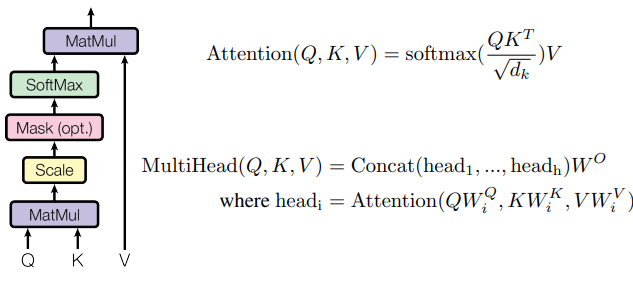

## Multi-Head-Attention

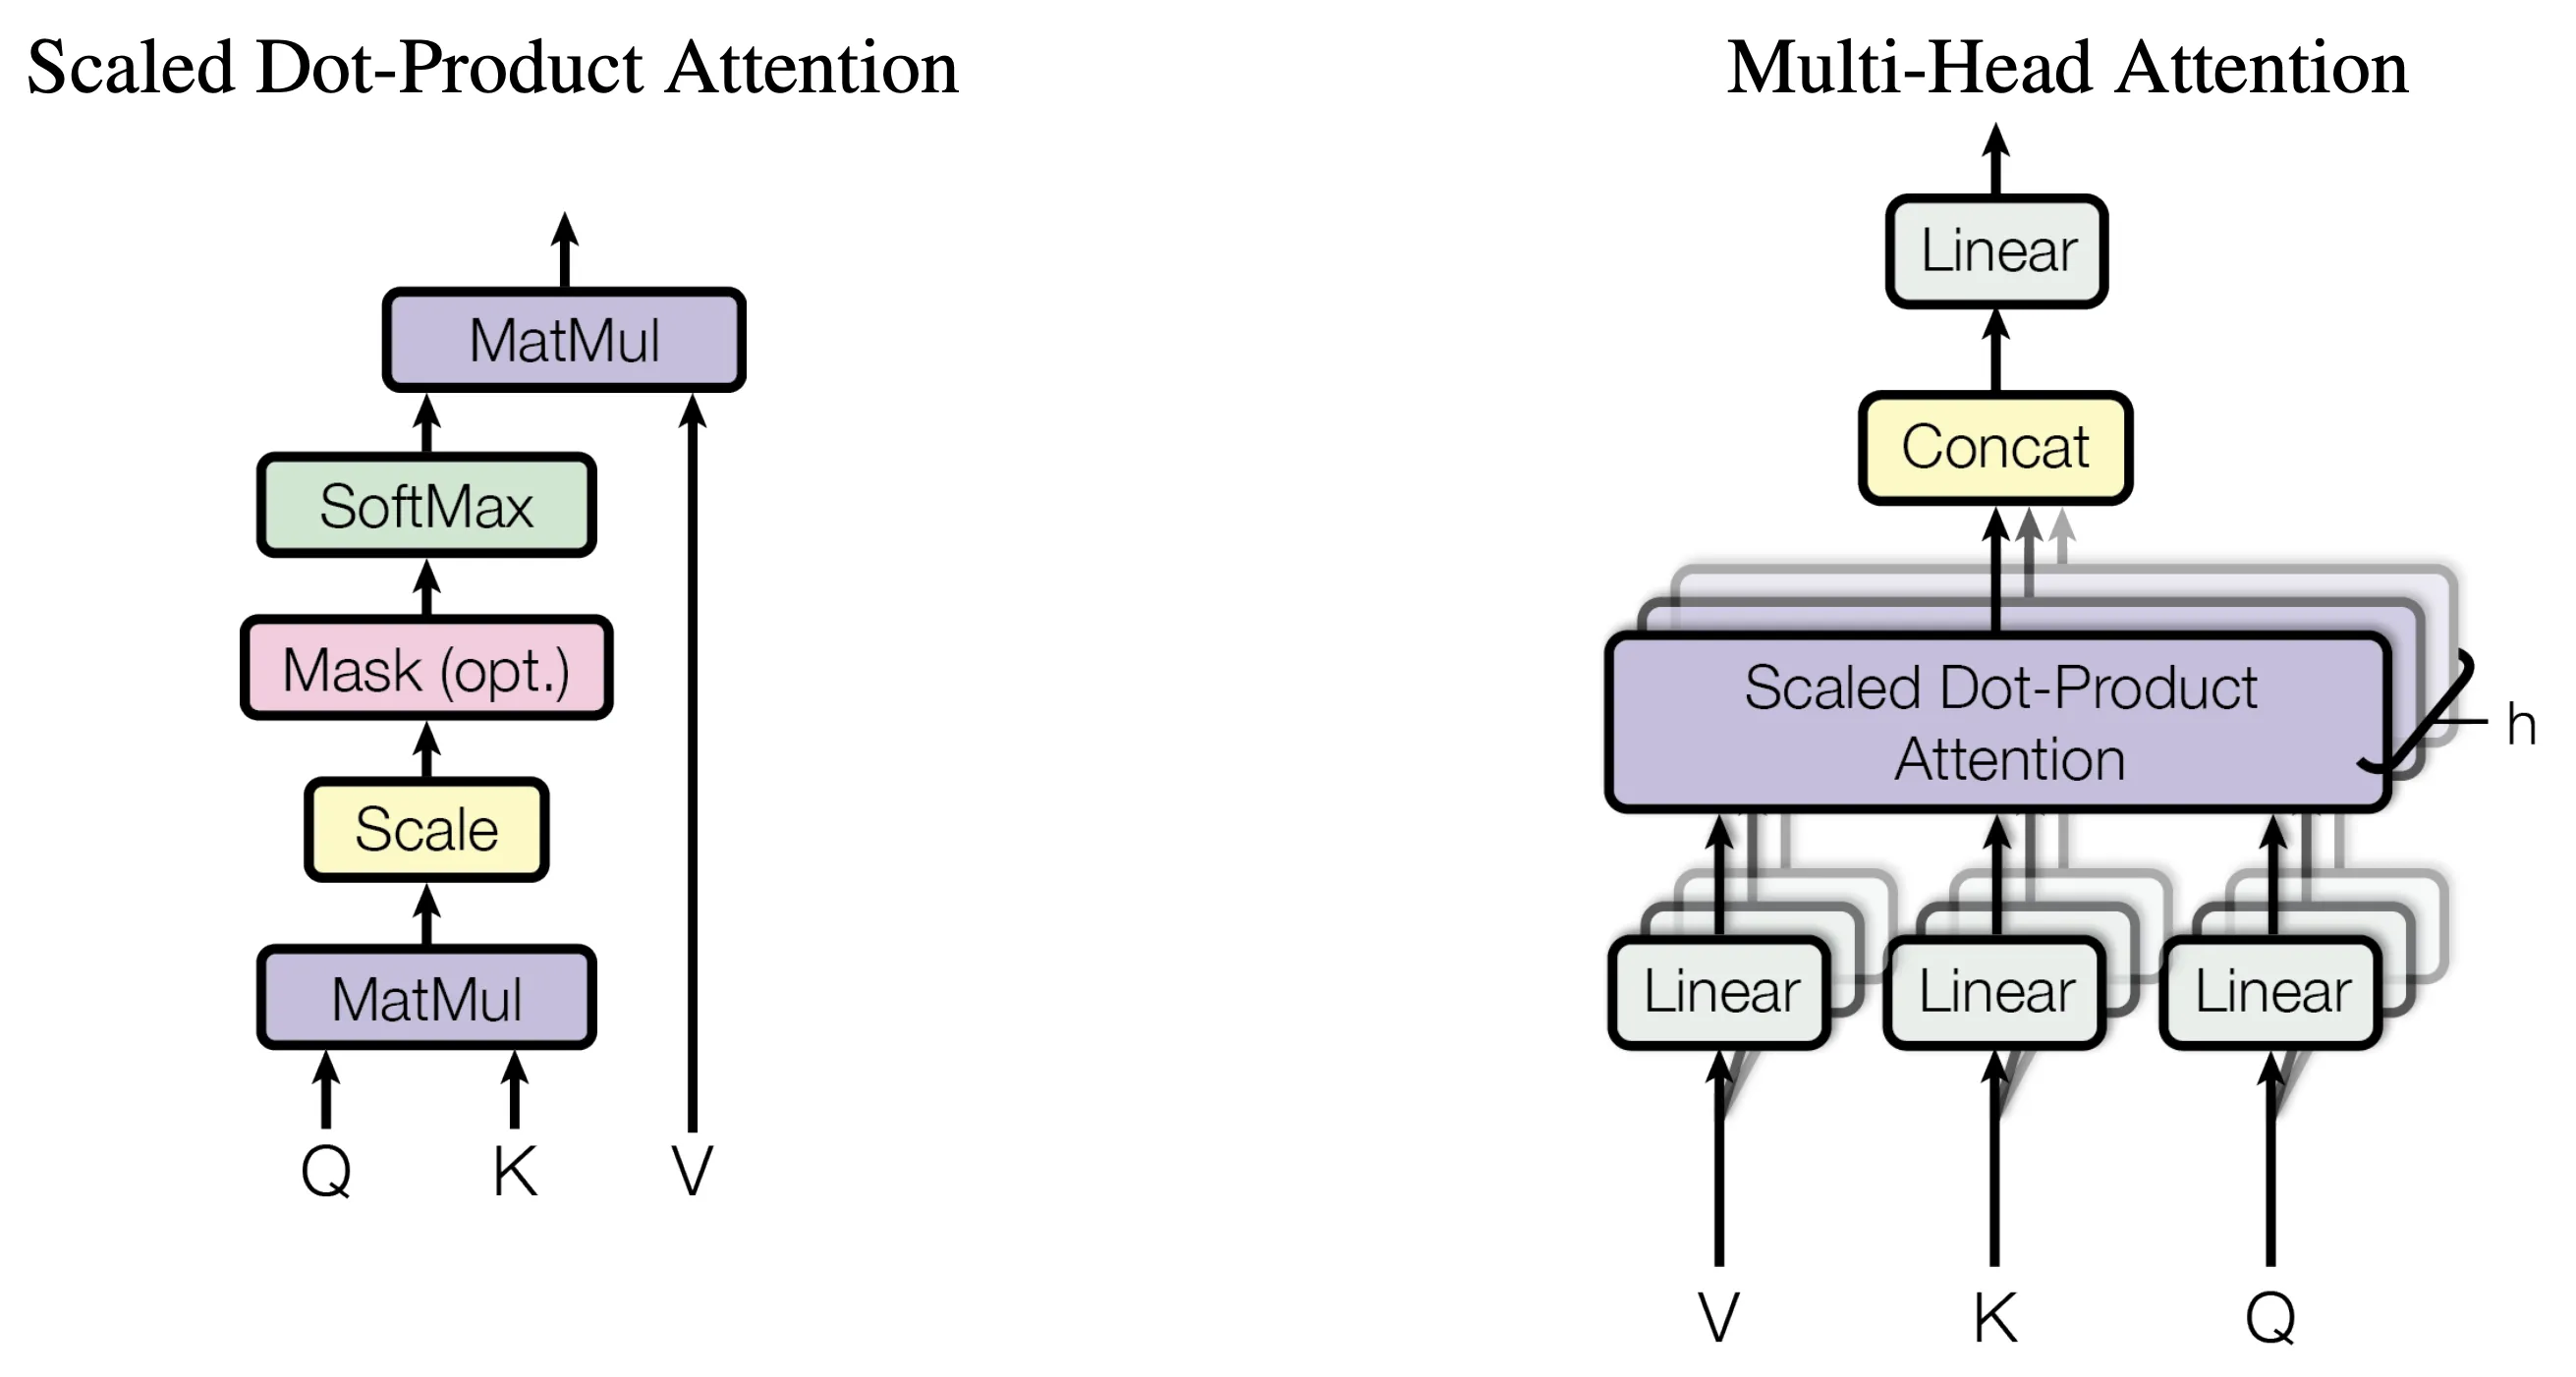

In [ ]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, dim_in, dim_out, context_length, num_heads, bias=False):
        super().__init__()

        self.dim_out = dim_out
        self.num_heads = num_heads
        self.head_dim = dim_out // num_heads
        assert dim_out % num_heads == 0

        self.wq = torch.nn.Linear(dim_in, dim_out, bias)
        self.wk = torch.nn.Linear(dim_in, dim_out, bias)
        self.wv = torch.nn.Linear(dim_in, dim_out, bias)
        self.wo_proj = torch.nn.Linear(dim_out, dim_out, bias)

        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        batch, num_tokens, d_in = x.shape
        queries = self.wq(x)
        keys = self.wk(x)
        values = self.wv(x)

        queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch, num_tokens, self.num_heads, self.head_dim)

        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        attention = queries @ keys.transpose(2, 3)
        attention.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens],
            -torch.inf
        )
        causal_attention = torch.softmax(attention / keys.shape[-1]**0.5,dim=-1)

        context_vec = causal_attention @ values
        context_vec = context_vec.transpose(1, 2)

        concat = context_vec.contiguous().view(batch, num_tokens, self.dim_out)
        concat = self.wo_proj(concat)

        return concat

### Teste do Multi-Head Attention

In [ ]:
# Teste de dimensões de saída do Multi-Head Attention

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tests = [
    {
        "hiperparams": {
            "context_length": 256,
            "embedding_dim": 512,
            "batch_size": 2,
            "bias": False,
            "num_heads": 8
        },
        "result": {
            "accept": True
        }
    },

    {
        "hiperparams": {
            "context_length": 256,
            "embedding_dim": 1024,
            "batch_size": 2,
            "bias": False,
            "num_heads": 8
        },
        "result": {
            "accept": True
        }
    }
]

for test in tests:
    hiperparams = test["hiperparams"]
    sample = torch.rand(
        hiperparams["batch_size"],
        hiperparams["context_length"],
        hiperparams["embedding_dim"],
        device=device
    )

    batch, tokens, embed_dim = sample.shape

    multi_head_attention = MultiHeadAttention(
        dim_in=embed_dim,
        dim_out=embed_dim,
        num_heads=8,
        context_length=tokens,
        bias=False
    ).to(device)

    multi_head_attention_forward = multi_head_attention(sample)

    if test["result"]["accept"]:
        assert sample.shape == multi_head_attention_forward.shape

## Normalização

### Layer Norm

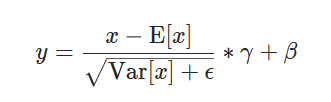

In [ ]:
# Queremos a média 0 e variância 1 para os embeddings de cada token

class LayerNorm(torch.nn.Module):
    def __init__(self, embedding_dim, epsilon = 1e-5):
        super().__init__()
        self.gama = torch.nn.Parameter(torch.ones(embedding_dim))
        self.beta = torch.nn.Parameter(torch.zeros(embedding_dim))
        self.epsilon = epsilon

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x = (x - mean) / torch.sqrt(var + self.epsilon)
        return x * self.gama + self.beta

### Teste do Layer Norm

In [ ]:
# Testando dimensões de saída da normalização z-score LayerNorm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch, tokens, embedding_dim = 2, 256, 512
sample = torch.rand(2, 256, 512, device=device)

norm = LayerNorm(embedding_dim=embedding_dim).to(device)
result = norm.forward(sample)

assert sample.shape == result.shape


sample_2 = torch.tensor([[[1.0, 2.0, 3.0]]])
norm_2 = LayerNorm(embedding_dim=sample_2.shape[2], epsilon=1e-5)
result_2 = norm_2.forward(sample_2)

mean = sample_2.mean(dim=-1, keepdim=True)
var = sample_2.var(dim=-1, unbiased=False, keepdim=True)
manual = (sample_2 - mean) / torch.sqrt(var + norm_2.epsilon)

assert sample_2.shape == result_2.shape
assert torch.equal(result_2, manual * norm_2.gama + norm_2.beta)

## Função de Ativação

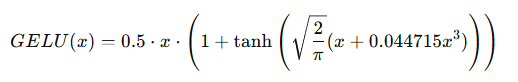

In [ ]:
class GELU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

### Teste do GELU

In [ ]:
# Testando dimensões de saída da função de ativação GeLU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gelu_test = torch.rand(2, 256, 512, device=device)
batch, context_length, embedding_dim = gelu_test.shape

gelu = GELU().to(device)
result = gelu.forward(gelu_test)

assert gelu_test.shape == result.shape

## FeedForward

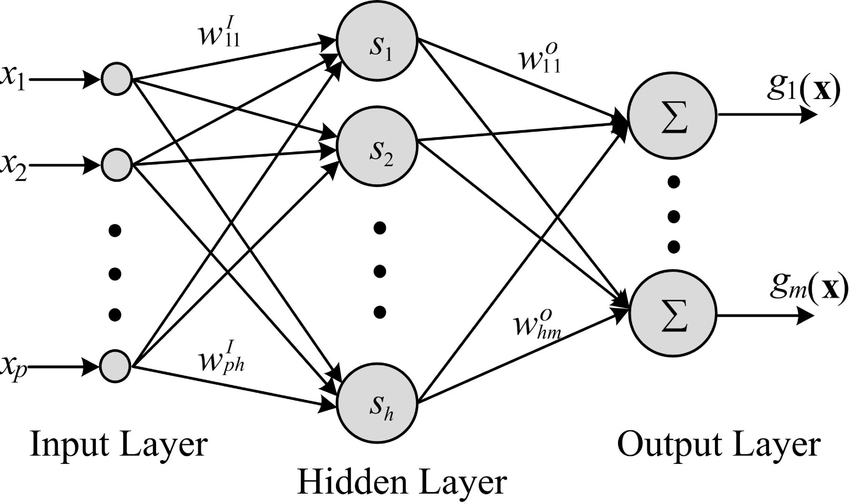

In [ ]:
# Usando autoencoder com overcomplete (dimensão da camada oculta maior que
# o tamanho da entrada) forçando a camada latente a ser esparsa para gerar
# representações esparsas interpretáveis, capturar relações não lineares
# (que o undercomplete não consegue) e descobrir estrutura latente em dados
# complexos.

class FeedForward(torch.nn.Module):
    def __init__(self, embedding_dim, bias=False):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(
                embedding_dim,
                4 * embedding_dim,
                bias=bias
            ),
            GELU(),
            torch.nn.Linear(
                4 * embedding_dim,
                embedding_dim,
                bias=bias
            )
        )

    def forward(self, x):
        return self.layers(x)

### Teste do FeedForward

In [ ]:
# Testando dimensões de saída do FeedForward
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feed_forward_test = torch.rand(2, 256, 512, device=device)
batch, context_length, embedding_dim = feed_forward_test.shape

feed_forward = FeedForward(embedding_dim=embedding_dim, bias=False).to(device)
result = feed_forward.forward(feed_forward_test)

assert feed_forward_test.shape == result.shape

## Bloco Transformer

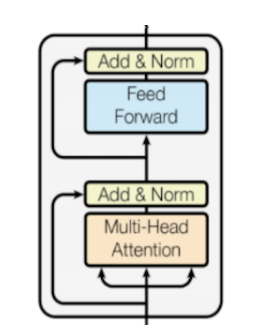

In [ ]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, context_length, dim_in, dim_out, num_heads, bias=False):
        super().__init__()

        # Usando a classe do Multi-Head Attention criada
        self.multi_head_attention = MultiHeadAttention(
            dim_in=dim_in,
            dim_out=dim_out,
            num_heads=num_heads,
            context_length=context_length,
            bias=bias
        )

        # Usando a classe do FeedForward criada
        self.feed_forward = FeedForward(
            embedding_dim=dim_in,
            bias=bias
        )

        self.norm1 = LayerNorm(
            embedding_dim=dim_in
        )

        self.norm2 = LayerNorm(
            embedding_dim=dim_in
        )


    def forward(self, x):
        residual_connection_attention = x
        norm1 = self.norm1.forward(x)
        attention_masked = self.multi_head_attention.forward(norm1)
        add1 = attention_masked + residual_connection_attention

        residual_connetion_forward = add1
        norm2 = self.norm2.forward(add1)
        forward = self.feed_forward(norm2)
        add2 = forward + residual_connetion_forward

        return add2

### Teste do bloco Transformer

In [ ]:
# Testando dimensões de saída do bloco transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer_block_test = torch.rand(2, 256, 512, device=device)
batch, context_length, embedding_dim = transformer_block_test.shape

transformer_block = TransformerBlock(
    context_length=context_length,
    dim_in=embedding_dim,
    dim_out=embedding_dim,
    num_heads=8,
    bias=False
).to(device)

result = transformer_block.forward(feed_forward_test)

assert transformer_block_test.shape == result.shape

## **Modelos**

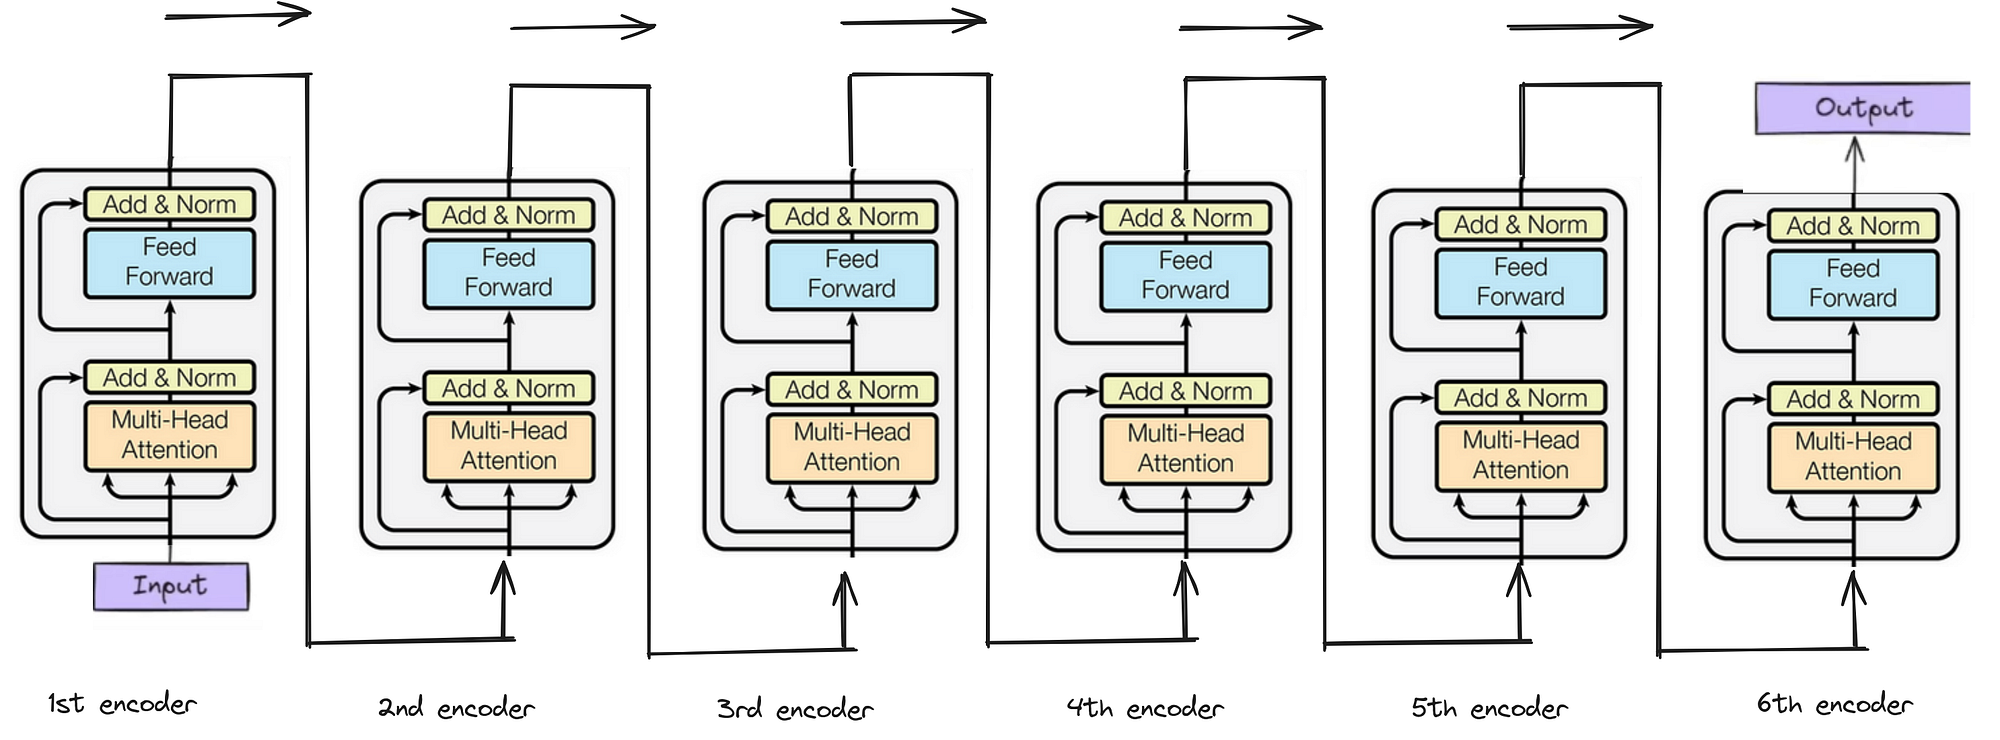

- Depois de passar pelos blocos transformers, como o tamamnho da saída do FeedForward é igual ao tamanho da entrada;
- Normalizamos os valores da saída dos blocos tansformers;
- Sabemos que as linhas de saída dos blocos transformers são os tokens e as colunas tem dimensão do embedding;
- Precisamos que cada token tenha dimensão do tamanho do vocabulário para saber a qual é o próximo token;
- Multiplica-se a saída por uma matriz de pesos, onde as linhas tem o tamanho do embedding e a saída igual o tamanho do vocabulário;
- Normalizamos a saída dos tokens com dimensão do vocab_size, pois multiplicamos por uma matriz de pesos que alterou a dimensão;
- Normalizamos usando o softmax;
- Após os tokens ter dimensão do vocab_size, o token 1 terá que ter maior score para o indíce do segundo token mais provável (token 2);
- O token 2 terá que ter maior score para o indíce do segundo token mais provável a ser o token 3, e assim em diante;
- Para gerar o próximo token, recuperamos o último token e buscamos qual é o índice do token com maior score (mais provável);
- Para recuperar o mais provável, como buscamos o índice da coluna com o maior score, usamos a função argmax.

### GPT2: Com Positional Encoding

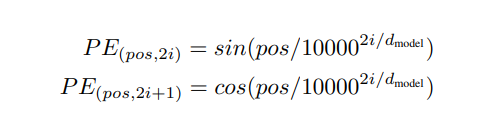

In [ ]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, embedding_dim, max_length):
        super().__init__()

        pe = torch.zeros(max_length, embedding_dim)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embedding_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Adiciona dimensão de batch = 1: (1, max_length, embedding_dim)
        pe = pe.unsqueeze(0)

        # Registra como buffer para ser movido automaticamente para GPU
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, seq_len)
        seq_len = x.size(1)  # Pega apenas o comprimento da sequência
        return self.pe[:, :seq_len, :]  # Retorna (1, seq_len, embedding_dim)

In [ ]:
class GPT2ModelPE(torch.nn.Module):
    def __init__(self, config, device):
        super().__init__()

        self.device = device

        self.emb= torch.nn.Embedding(config["vocab_size"], config["embedding_dim"])

        self.pos_encoding = PositionalEncoding(
            embedding_dim=config["embedding_dim"],
            max_length=config["context_length"]
        )

        self.transformer_blocks = torch.nn.Sequential(*[
            TransformerBlock(
                context_length=config["context_length"],
                dim_in=config["embedding_dim"],
                dim_out=config["embedding_dim"],
                num_heads=config["num_heads"],
                bias=config["bias"]
            )
            for _ in range(config["num_layers"])
        ])

        self.final_norm = LayerNorm(
            embedding_dim=config["embedding_dim"],
            epsilon=1e-5
        )

        self.out_head = torch.nn.Linear(
            config["embedding_dim"],
            config["vocab_size"],
            bias=config["bias"]
        )


    def forward(self, x):
        input_emb = self.emb(x)
        pos_encoding = self.pos_encoding(x)
        input = input_emb + pos_encoding

        result_transformer_blocks = self.transformer_blocks(input)
        norm = self.final_norm(result_transformer_blocks)
        logits = self.out_head(norm)

        return logits

### Teste do GPT 2 com Positional Encoding

In [ ]:
# Testando dimensões de saída do modelo GPT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config_test = {
    "vocab_size": 100,
    "embedding_dim": 512,
    "context_length": 256,
    "num_layers": 8,
    "num_heads": 8,
    "bias": False
}

test_gpt_model = torch.randint(
    high=config_test["vocab_size"],
    size=(2, config_test["context_length"]),
    device=device
)

model_test = GPT2ModelPE(config=config_test, device=device).to(device)
model_test_forward = model_test.forward(test_gpt_model)

assert model_test_forward.shape == (2, 256, config_test["vocab_size"])

# **Experimentos 🧪**

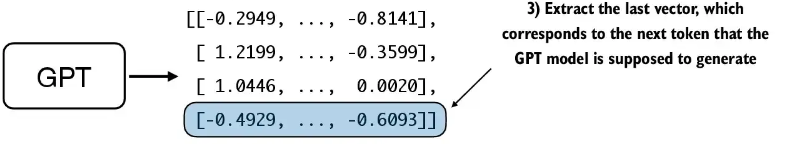

- A dimensão da saída do GPT são os tokens da sentença, vocab_size;

> Adicionar aspas


- Extrai-se o último token, pois ele carrega a informação de qual palavra vem a seguir;
- Normaliza-se os valores com softmax;
- Extrai-se o índice do token do vocabulário com a maior probabilidade;
- O ID token selecionado será concatenado a lista de tokens da sentença.

## Geração de Texto

In [ ]:
def generate_text(model, idx, max_new_tokens, context_size=50, reset=False):
    model.eval()
    reset = False

    try:
        for i in range((max_new_tokens + 1) if reset else max_new_tokens):
            idx_cond = idx[:, -context_size:]
            with torch.no_grad():
                logits = model(idx_cond, reset) if reset else model(idx_cond)
                if logits == None: continue

            reset = False

            logits = logits[:, -1, :]
            probas = torch.nn.functional.softmax(logits, dim=-1)
            idx_next_token = torch.argmax(probas, dim=-1, keepdim=True)
            idx = torch.cat((idx, idx_next_token), dim=1)

        return idx

    except Exception as e:
        print(e)
        return idx

## Conjunto de Funções para Salvar os pesos do Modelo

In [ ]:
# def fetch_weights_and_bias(user, project, name, version, file_name):
#     try:
#         api = wandb.Api()
#         #wandb.init(project=project, name=name)
#         run = api.run(f"{user}/{project}/{version}")
#         run.file(file_name).download(replace=True)
#         print("Fetch success")

#         return True

#     except Exception as e:
#         print("Fetch Error")
#         return False

def fetch_weights_and_bias(user, project, name, version, file_name):
    """
    Busca um artifact de pesos salvo no W&B.
    Exemplo de version: 'v1', 'v2', etc (não o run id).
    """
    try:
        api = wandb.Api()
        artifact = api.artifact(f"{user}/{project}/{name}:{version}", type="model")
        artifact_dir = artifact.download()
        file_path = os.path.join(artifact_dir, file_name)
        print(f"Fetch success -> {file_path}")
        return True

    except Exception as e:
        print(f"Fetch Error: {e}")
        return False

def load_weights_and_bias(file_name):
    try:
        checkpoint = torch.load(file_name, map_location="cpu")
        return True, checkpoint
    except Exception as e:
        print(f"Load error: {e}")
        return False, {}

# def load_weights_and_bias(file_name):
#     try:
#         return True, torch.load(file_name)

#     except Exception as e:
#         print("Load error")
#         return False, {}

In [ ]:
#os.environ["WANDB_API_KEY"] = "5ca14c4352d864370bad3199b26c5dab929ba976"
os.environ["WANDB_API_KEY"] = "8dc112bdcb6f80c3fb20da526d4a52923f2074f2"

def train_model(model, optimizer, config):
    run = wandb.init(project=config["project"], name=config["name"], id=config["run_id"], resume="allow")
    res_fetch = fetch_weights_and_bias(
        #wandb=run,
        user=config["user"],
        project=config["project"],
        name=config["name"],
        version=config["version"],
        file_name=config["file_name"]
    )

    state_dict = {}
    if res_fetch:
        loaded, checkpoint = load_weights_and_bias(
            file_name=config["file_name"]
        )
        if loaded:
            model.load_state_dict(checkpoint["model_state"])
            optimizer.load_state_dict(checkpoint["optimizer_state"])
            state_dict["epoch"] = checkpoint.get("epoch", 0)
            state_dict["batch"] = checkpoint.get("batch", 0)
            state_dict["train_time"] = checkpoint.get("train_time", 0.0)
            print("Pesos carregados com sucesso!")

    print("\nEPOCHS/BATCHS RECUPERADOS: ", state_dict)
    num_epochs = config["max_epochs"]

    start_time = time.time()
    train_losses, val_losses, tokens_seen, total_train_time = train_model_simple(
        run, model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=5, eval_iter=5,
        start_context="Bom dia!", tokenizer=tokenizer,
        save_freq_wdb=config["save_freq_wdb"], file_name=config["file_name"],
        save_wdb=config["save_wdb"], state_dict=state_dict,
        project=config["project"], name=config["name"], start_time=start_time
    )
    print("\nGRÁFICO DE PERDA DURANTE O TREINO:")
    epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
    plot_graph(epochs_tensor, tokens_seen, train_losses, val_losses)
    # Retorna o número de tokens processados. Isso irá ajuda na quantidade de tokens/s
    return tokens_seen[-1], total_train_time

## Conjunto de Funções para Treinamento e Avaliação do Modelo

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_graph(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Perda no Treino")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Perda na Validação")
    ax1.set_xlabel("Épocas")
    ax1.set_ylabel("Perda")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens Vistos")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

In [ ]:
def calc_loss_batch_by_cross_entropy(model, input_batch, target_batch, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1),
        target_batch.flatten()
    )

    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch_by_cross_entropy(
                input_batch=input_batch,
                target_batch=target_batch,
                model=model,
                device=device
            )

            total_loss += loss.item()
        else:
            break

    return total_loss

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )

    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    if hasattr(model, 'pos_embeddings'):
      context_size = model.pos_embeddings.weight.shape[0]
    elif hasattr(model, 'pos_encoding'):
      context_size = model.pos_encoding.pe.size(1)
    else:
      # Fallback padrão
      context_size = 256
      print(f"Usando context_size padrão: {context_size}")
    encoded = text_to_token_ids(start_context, tokenizer, device).to(device)
    with torch.no_grad():
        token_ids = generate_text(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer, device)
    print(decoded_text.replace("\n", " "))
    model.train()


def train_model_simple(
        wandb_run, model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer,
        save_freq_wdb, file_name, save_wdb, state_dict, project, name, start_time
):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    epochs_complete = state_dict.get("epoch", 0)
    batchs_complete = state_dict.get("batch", 0)
    accumulated_time = state_dict.get("train_time", 0)

    for epoch in range(epochs_complete, num_epochs):
        model.train()

        for batch_idx, (input_batch, target_batch) in enumerate(train_loader):
            if epoch == epochs_complete and batch_idx < batchs_complete:
                continue

            optimizer.zero_grad()
            loss = calc_loss_batch_by_cross_entropy(
                model,
                input_batch,
                target_batch,
                device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model,
                    train_loader,
                    val_loader,
                    device,
                    eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                wandb_run.log({
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "tokens_seen": tokens_seen,
                    "epoch": epoch + 1,
                    "global_step": global_step,
                })

                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

            # salva peso só após o primeiro batch
            if save_wdb and global_step > 0 and global_step % save_freq_wdb == 0:
                elapsed_time = time.time() - start_time + accumulated_time
                torch.save({
                    "epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "batch": batch_idx,
                    "train_time": elapsed_time
                },  file_name)
                # wandb.init(project=project, name=name)
                # wandb.save(file_name)
                #artifact = wandb.Artifact(file_name.split(".")[0], type='model')
                artifact = wandb.Artifact(name, type="model")
                artifact.add_file(file_name)
                wandb_run.log_artifact(artifact)
                #wandb.finish()
        print("\nEXEMPLO DE GERAÇÃO:")
        generate_and_print_sample(model, tokenizer, device, start_context)

        # salva após finalizar o treino
        elapsed_time = time.time() - start_time + accumulated_time
        if save_wdb:
          torch.save({
              "epoch": epoch,
              "model_state": model.state_dict(),
              "optimizer_state": optimizer.state_dict(),
              "batch": batch_idx,
              "train_time": elapsed_time
          },  file_name)
          artifact = wandb.Artifact(file_name.split(".")[0] + "_final", type="model")
          artifact.add_file(file_name)
          wandb_run.log_artifact(artifact)

    return train_losses, val_losses, track_tokens_seen, elapsed_time

## Treinamento dos Modelos + Prova de Convergência

### GPT2: PE

Número de parâmetros (sem head): 127,592,960


wandb: Currently logged in as: matheus-figueiredo-silva (matheus-figueiredo-silva-ufcg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Fetch Error: artifact 'gpt2pe:v0' not found in 'matheus-figueiredo-silva-ufcg/gpt2'

EPOCHS/BATCHS RECUPERADOS:  {}
Ep 1 (Step 000000): Train loss 58.095, Val loss 58.127
Ep 1 (Step 000005): Train loss 51.904, Val loss 51.239
Ep 1 (Step 000010): Train loss 45.946, Val loss 45.376
Ep 1 (Step 000015): Train loss 41.319, Val loss 40.391
Ep 1 (Step 000020): Train loss 38.245, Val loss 38.357
Ep 1 (Step 000025): Train loss 37.686, Val loss 37.626
Ep 1 (Step 000030): Train loss 37.508, Val loss 37.090
Ep 1 (Step 000035): Train loss 37.063, Val loss 37.164
Ep 1 (Step 000040): Train loss 36.945, Val loss 36.886
Ep 1 (Step 000045): Train loss 37.225, Val loss 36.636
Ep 1 (Step 000050): Train loss 35.594, Val loss 36.421
Ep 1 (Step 000055): Train loss 36.021, Val loss 35.846
Ep 1 (Step 000060): Train loss 35.827, Val loss 35.434
Ep 1 (Step 000065): Train loss 34.763, Val loss 35.278
Ep 1 (Step 000070): Train loss 34.479, Val loss 35.216
Ep 1 (Step 000075): Train loss 34.273, Val loss 34.810
Ep 1

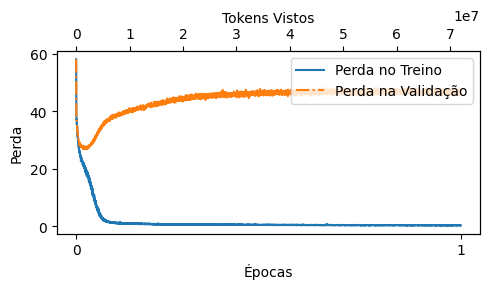


DESEMPENHO:
Tempo total: 18806.10 s
Tokens/s: 3827.35
Memória máxima: 11124.57 MB

Tempo total de treino: 18765.01 s (312.75 min)


In [ ]:
torch.manual_seed(123)

config = {
    "vocab_size": tokenizer.n_vocab,
    "embedding_dim": 512,
    "context_length": 250,
    "num_layers": 8,
    "num_heads": 8,
    "bias": False,
    "max_epochs": 1,
    "dtype": torch.float32,
    "save_wdb": True,
    "save_freq_wdb": 5000,
    "user": "matheus-figueiredo-silva-ufcg",
    "project": "gpt2",
    "name": "gpt2pe",
    "run_id": "gpt2pe-run1",
    "version": "v0",
    "file_name": "mini_mlp.pth"
}

# Inicializa modelo
model_pe = GPT2ModelPE(config, device).to(device=device)
optimizer = torch.optim.AdamW(model_pe.parameters(), lr=0.0004, weight_decay=0.1)

params = sum(p.numel() for p in model_pe.parameters())
params_gpt2 = params - sum(p.numel() for p in model_pe.out_head.parameters())
print(f"Número de parâmetros (sem head): {params_gpt2:,}")

# Medir tokens/s
torch.cuda.reset_peak_memory_stats(device)

start_time = time.time()
tokens_processed, total_train_time = train_model(model=model_pe, optimizer=optimizer, config=config)
end_time = time.time()

elapsed = end_time - start_time
tokens_per_sec = tokens_processed / elapsed
max_memory = torch.cuda.max_memory_allocated(device) / (1024**2)  # MB

print("\nDESEMPENHO:")
print(f"Tempo total: {elapsed:.2f} s")
print(f"Tokens/s: {tokens_per_sec:.2f}")
print(f"Memória máxima: {max_memory:.2f} MB")

print(f"\nTempo total de treino: {total_train_time:.2f} s ({total_train_time/60:.2f} min)")

In [ ]:
generate_and_print_sample(model_pe, tokenizer, device=device, start_context="temia")

temia muito, e eu disse delle cousa nenhuma, que não fosse pessoa nasce-me sentir a negar que lhe confidente obede a acção, isto é aia deste livro, alguma cousa, e não sou seu.  


# **Resultados ✨**

## Perplexidade

In [ ]:
def compute_perplexity(model, data_loader, device):
    model.eval()
    total_loss = 0
    n_batches = 0

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(data_loader):
            x, y = x.to(device), y.to(device)
            loss = calc_loss_batch_by_cross_entropy(model, x, y, device)

            print(f"Batch {batch_idx+1}/{len(data_loader)}, Loss: {loss.item():.4f}")

            total_loss += loss.item()
            n_batches += 1

            if (batch_idx + 1) % 10 == 0:
                avg_loss_partial = total_loss / n_batches
                print(f"  Média parcial até aqui: {avg_loss_partial:.4f}")

    avg_loss = total_loss / n_batches
    print(f"Loss média final no dataset de teste: {avg_loss:.4f}")

    perplexity = torch.exp(torch.tensor(avg_loss))
    print(f"Perplexidade calculada: {perplexity.item():.2f}")

    return perplexity.item()

perplexity_test = compute_perplexity(model_pe, test_loader, device)

Batch 1/3471, Loss: 7.5082
Batch 2/3471, Loss: 7.7070
Batch 3/3471, Loss: 6.8044
Batch 4/3471, Loss: 9.4617
Batch 5/3471, Loss: 8.6227
Batch 6/3471, Loss: 9.1145
Batch 7/3471, Loss: 9.6229
Batch 8/3471, Loss: 9.9673
Batch 9/3471, Loss: 10.1225
Batch 10/3471, Loss: 9.8054
  Média parcial até aqui: 8.8736
Batch 11/3471, Loss: 9.0455
Batch 12/3471, Loss: 7.8781
Batch 13/3471, Loss: 9.6352
Batch 14/3471, Loss: 10.1038
Batch 15/3471, Loss: 8.5156
Batch 16/3471, Loss: 9.9816
Batch 17/3471, Loss: 10.0192
Batch 18/3471, Loss: 8.3463
Batch 19/3471, Loss: 8.7423
Batch 20/3471, Loss: 9.3760
  Média parcial até aqui: 9.0190
Batch 21/3471, Loss: 8.3955
Batch 22/3471, Loss: 8.5673
Batch 23/3471, Loss: 8.7055
Batch 24/3471, Loss: 7.3994
Batch 25/3471, Loss: 9.7747
Batch 26/3471, Loss: 7.6313
Batch 27/3471, Loss: 7.9827
Batch 28/3471, Loss: 10.3767
Batch 29/3471, Loss: 8.8191
Batch 30/3471, Loss: 7.9831
  Média parcial até aqui: 8.8672
Batch 31/3471, Loss: 8.8898
Batch 32/3471, Loss: 9.4597
Batch 33/3

## Função auxiliar para carregar o modelo treinado salvo no wandb

In [ ]:
def load_latest_model(config, model_class, device):
    api = wandb.Api()
    artifact = api.artifact(
        f"{config['user']}/{config['project']}/{config['name']}:latest", type="model"
    )
    artifact_dir = artifact.download()

    checkpoint_path = os.path.join(artifact_dir, config["file_name"])
    print(f"Carregando pesos do checkpoint: {checkpoint_path}")

    # Carregar o checkpoint completo
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Inicializa modelo com a mesma config
    model = model_class(config, device).to(device)

    # Corrige: só pega os pesos do modelo
    model.load_state_dict(checkpoint["model_state"])
    print("Pesos carregaos com sucesso!")

    return model

In [ ]:
config = {
    "vocab_size": tokenizer.n_vocab,
    "embedding_dim": 512,
    "context_length": 250,
    "num_layers": 8,
    "num_heads": 8,
    "bias": False,
    "max_epochs": 1,
    "dtype": torch.float32,
    "user": "matheus-figueiredo-silva-ufcg",
    "project": "gpt2",
    "name": "mini_mlp_final",
    "run_id": "gpt2pe-run1",
    "version": "v0",
    "file_name": "mini_mlp.pth"
}

model_loaded = load_latest_model(config, GPT2ModelPE, device)

wandb: Downloading large artifact mini_mlp_final:latest, 2634.67MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:13.5 (195.1MB/s)


Carregando pesos do checkpoint: /kaggle/working/artifacts/mini_mlp_final:v0/mini_mlp.pth


## Gerações de Texto

In [ ]:
generate_and_print_sample(model_loaded, tokenizer, device, start_context="temia")

temia a consciencia se accommoda; Sacrificios de amor não sonha nem procura; Não lhes pede illusões, pede-lhes só ternura. Não me empenho em achar alma ungida no céu: Se é crime este sentir


In [ ]:
generate_and_print_sample(model_loaded, tokenizer, device, start_context="desde quando")

desde quando a trombeta soou devéras, e Ashaverus bradou pela terceira vez que era a do archanjo, um gaiato da platéa corrigiu cá debaixo: «Não, senhor, é o piston


In [ ]:
generate_and_print_sample(model_loaded, tokenizer, device, start_context="eu sou rei")

eu sou rei, e saí; muitos annos, nem de um dia, uma filhade, um cainho de palmeza e attenção; a attenção ou, um projecto para que, ao ver se era preciso dignidade


In [ ]:
generate_and_print_sample(model_loaded, tokenizer, device, start_context="Deus")

Deus, D. Justina, se ainda solto é, meu amigo, um grande avio, quando sepulchro, quando os seus olhos, já de quando. O Era só, seu proprio Humanitismo poderia ser, é


In [ ]:
generate_and_print_sample(model_loaded, tokenizer, device, start_context="carinho")

carinho, e não se; deixava ir estar quieta saía dellas. Quando elle estava, tinha oirava os-se ruidos de familia. Quando eram nós se falava só em casa, elle, só; só


In [ ]:
generate_and_print_sample(model_loaded, tokenizer, device, start_context="poema")

poema, e, para eu disse-me que o emende na segunda edição; nada ha mais feio que dar pernas longuissimas a ideias brevissimas. Enxuguei os olhos, repito, e fui andando, anci
